# Прогнозирование заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.
Построbv модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

# План работы
- Загрузим данные и выполним их ресемплирование по одному часу
- Проанализируем данные
- Подготовка данных и обучение
- Проверим данные на выборке
- Вывод

## Загрузим данные и выполним их ресемплирование по одному часу

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
import time

In [ ]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=['datetime'], parse_dates=['datetime'])
except:
    df = pd.read_csv('C:/Users/www/taxi.csv', index_col=['datetime'], parse_dates=['datetime'])

In [ ]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


у нас данные с цикличностью 10 минут, ресемплируем их

In [ ]:
df = df.resample('1H').sum()

In [ ]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Создадим две переменные, одну для сравнения какая выборка(исходная или полученная путем разности рядов) более стационарна а вторую для создания корректных признаков признаков

In [ ]:
df_1 = df.copy()
df_2 = df.copy()

In [ ]:
df["rolling_mean"] = df["num_orders"].rolling(20).mean()
df["rolling_std"] = df["num_orders"].rolling(20).std()

class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корректно, первичный осмотр проведен. Ресемплинг был сделан верно.
</div>

## Проанализируем данные

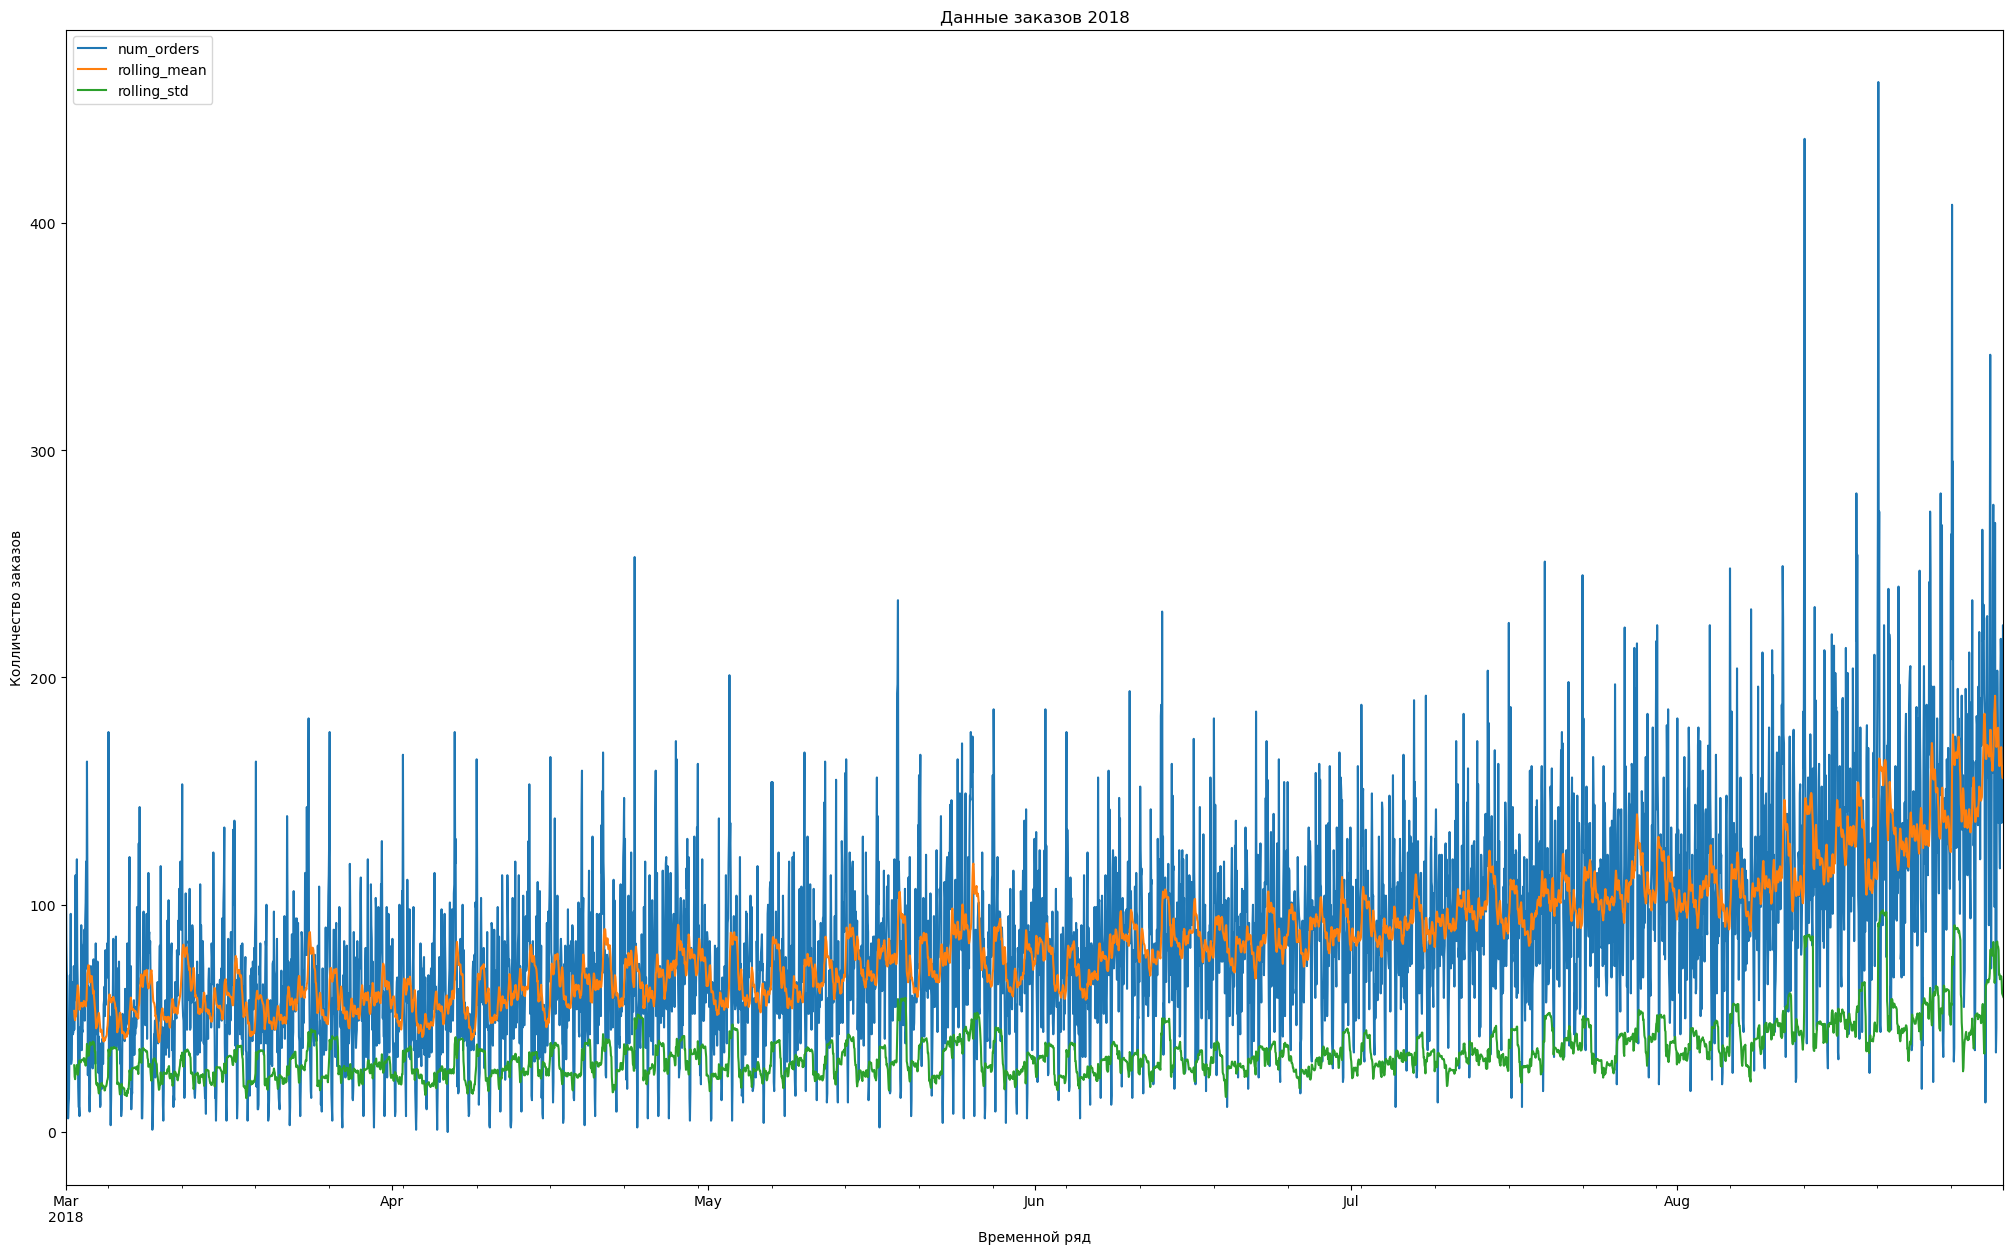

In [ ]:
df.plot(figsize=(25,15))
plt.title('Данные заказов 2018')
plt.xlabel('Временной ряд')
plt.ylabel('Колличество заказов')
plt.legend(loc='best')
plt.show()

Изначально выборка достаточно стационарна, посмотрим ли сильно измениться ситуация, если получить разность ряда

In [ ]:
df_1 = df - df.shift()

In [ ]:
df_1["rolling_mean"] = df_1["num_orders"].rolling(20).mean()
df_1["rolling_std"] = df_1["num_orders"].rolling(20).std()

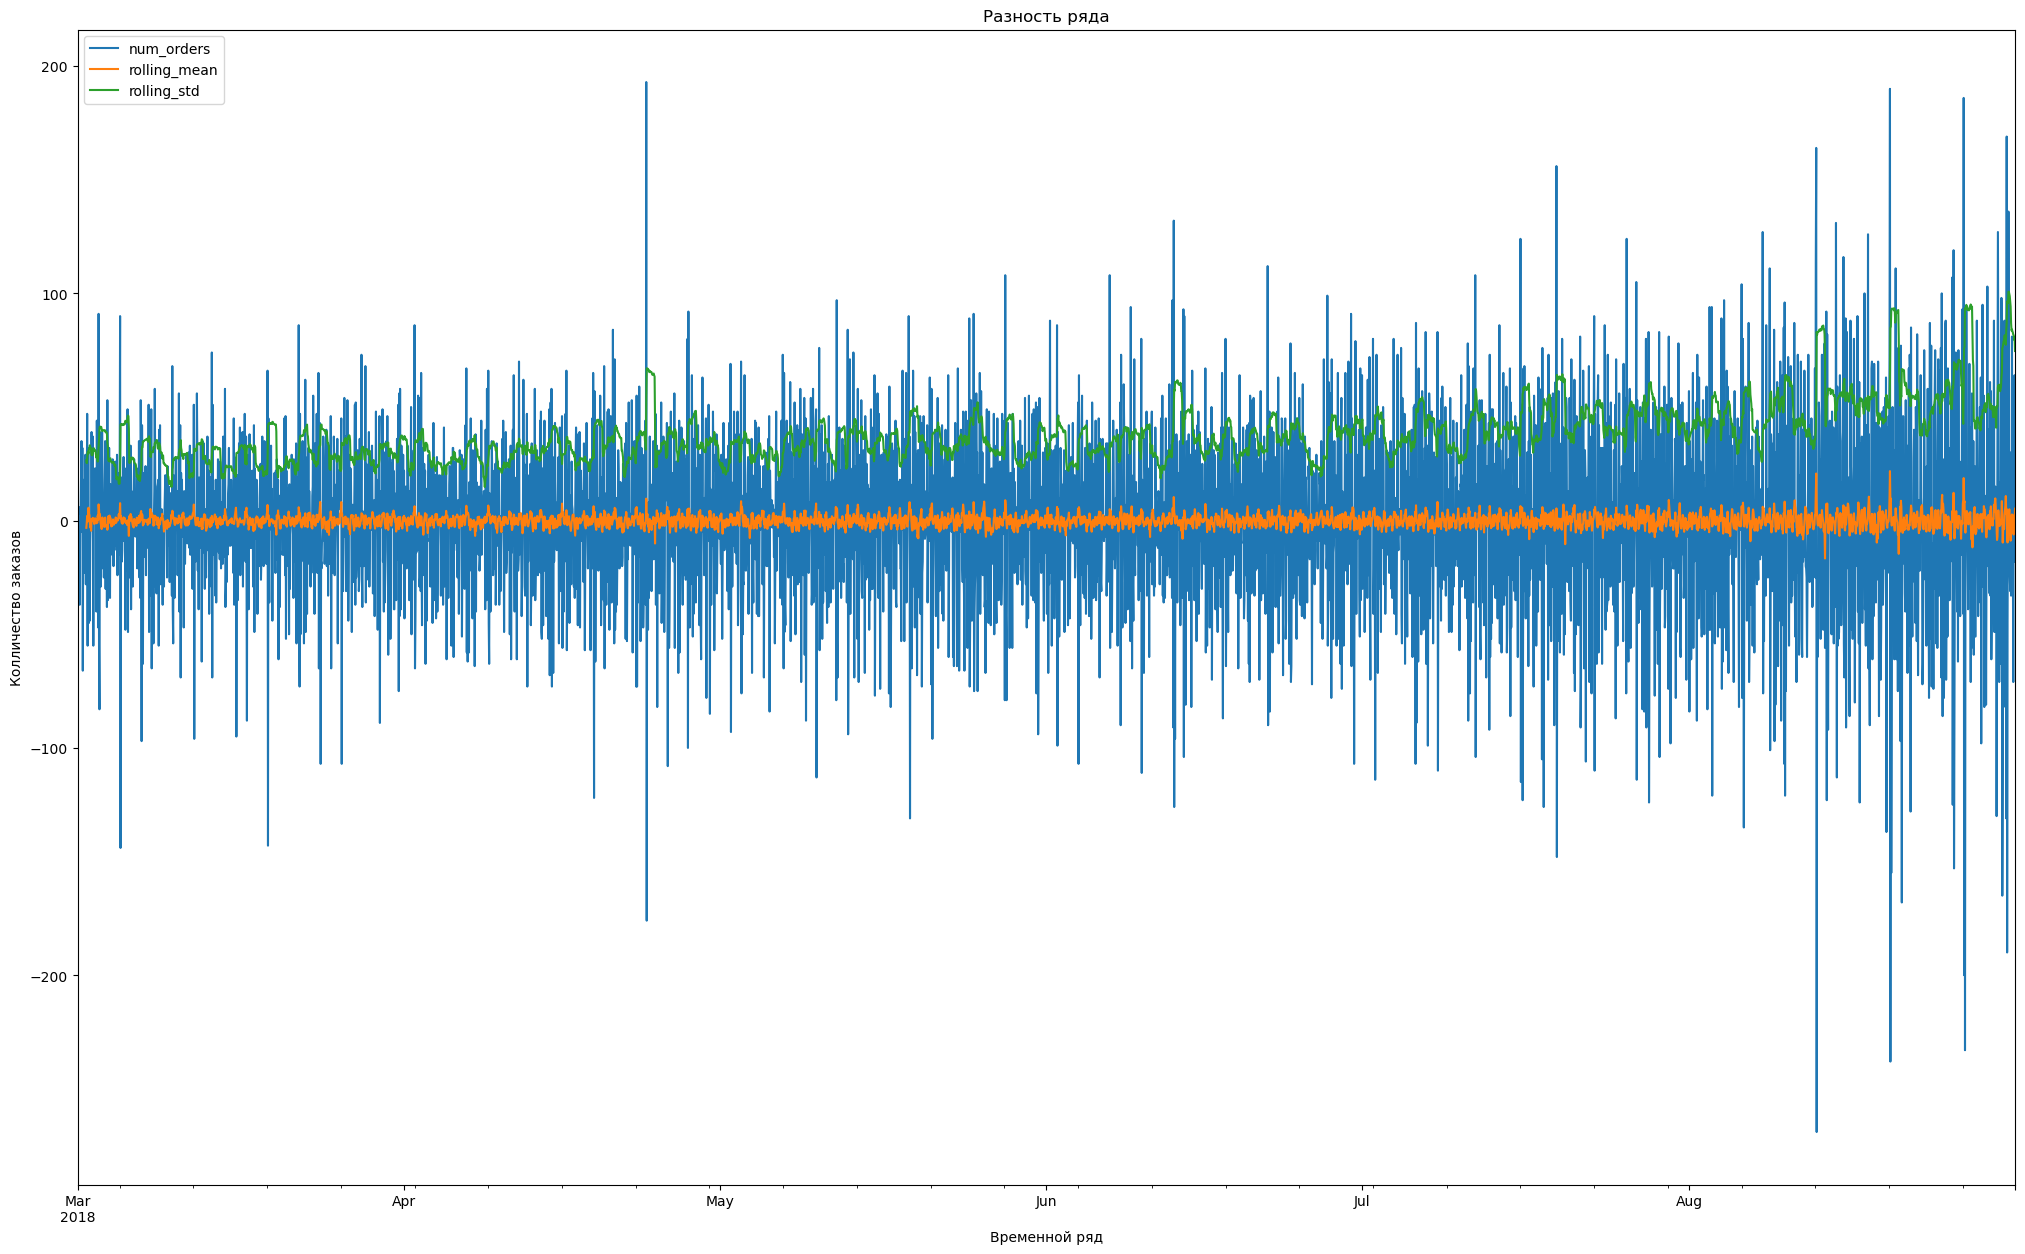

In [ ]:
df_1.plot(figsize=(25,15))
plt.title('Разность ряда')
plt.xlabel('Временной ряд')
plt.ylabel('Колличество заказов')
plt.legend(loc='best')
plt.show()

визуально можно определить что наш рад стационарный

In [ ]:
df_1.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,4415.0,0.018347,39.023437,-269.000000,-22.000000,1.00000,23.00000,193.000000
rolling_mean,4396.0,0.024488,2.801253,-16.650000,-1.750000,-0.05000,1.65000,21.800000
rolling_std,4396.0,37.989795,12.318616,14.839049,29.647457,35.85965,43.48072,100.717675


Удалю признаки, которые использовались для анализа и создадим новые, которые не будут получены на истинном целевом признаке

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [ ]:
make_features(df_2,24,20)

Построим графики для сезонности и для тренда

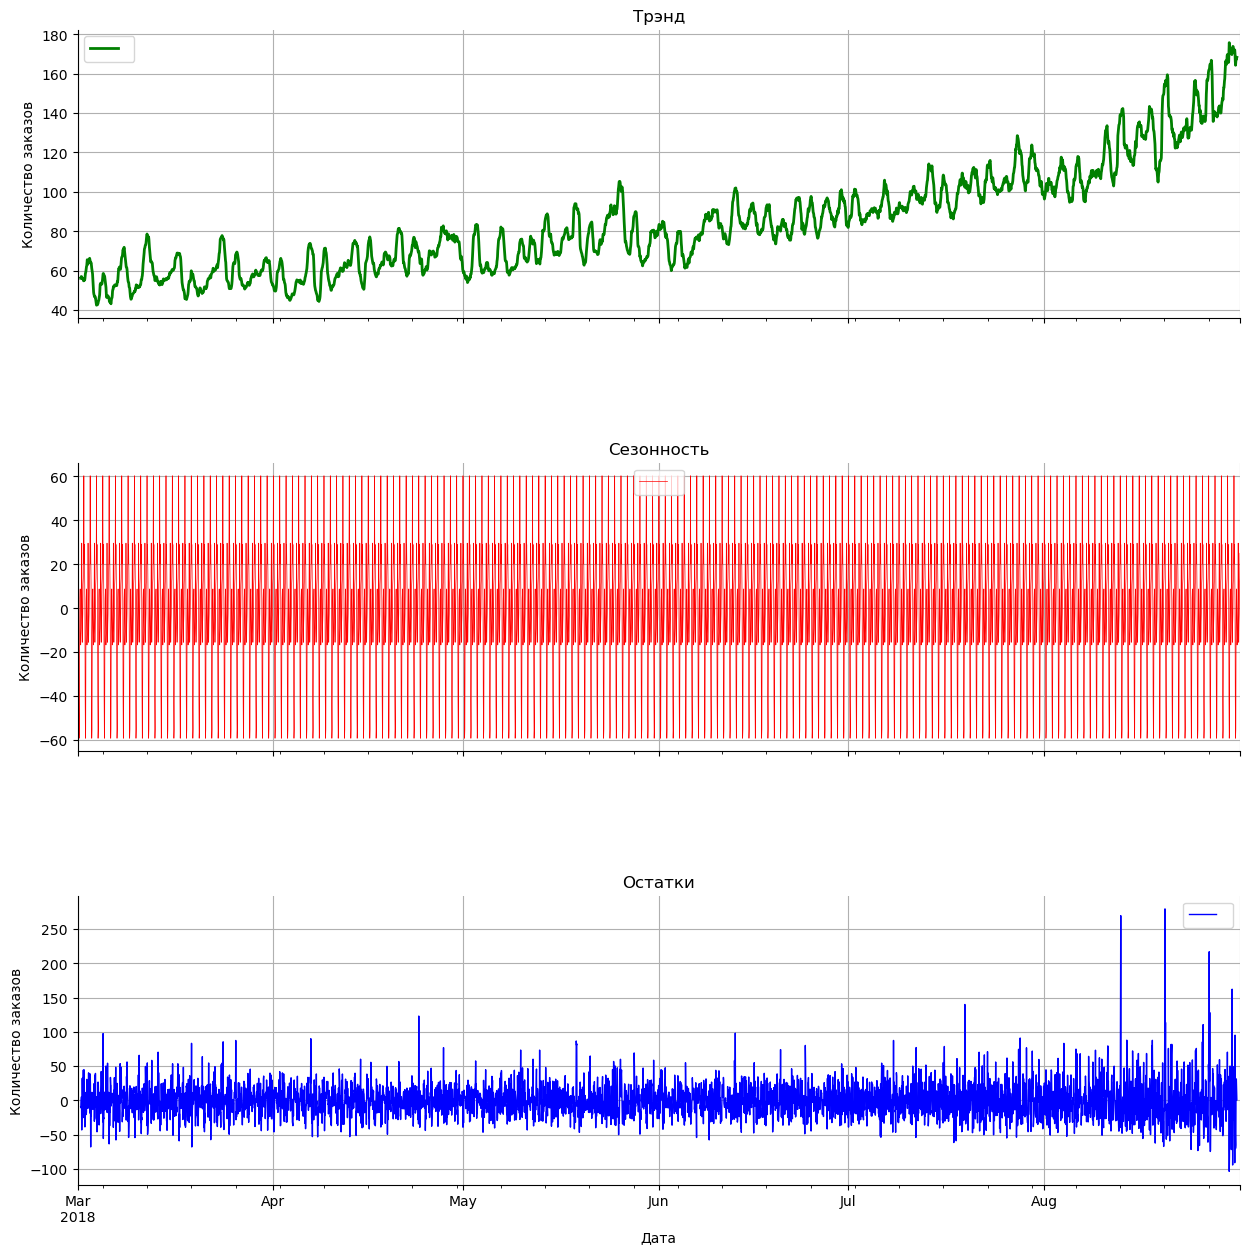

In [ ]:
decomposed = seasonal_decompose(df_2["num_orders"])

fig, ax = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

decomposed.trend.plot(ax=ax[0], color='green', linewidth=2)
ax[0].set_title('Трэнд')
ax[0].set_ylabel('Количество заказов')
ax[0].grid(True)

decomposed.seasonal.plot(ax=ax[1], color='red', linewidth=0.5)
ax[1].set_title('Сезонность')
ax[1].set_ylabel('Количество заказов')
ax[1].grid(True)

decomposed.resid.plot(ax=ax[2], color='blue', linewidth=1)
ax[2].set_title('Остатки')
ax[2].set_xlabel('Дата')
ax[2].set_ylabel('Количество заказов')
ax[2].grid(True)

for axis in ax:
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    axis.legend([''])

plt.subplots_adjust(hspace=0.5)
plt.show()


Проанализируем сезонность на заданном промежутке времени

Text(0.5, 1.0, 'Сезонность четвертая неделя апреля')

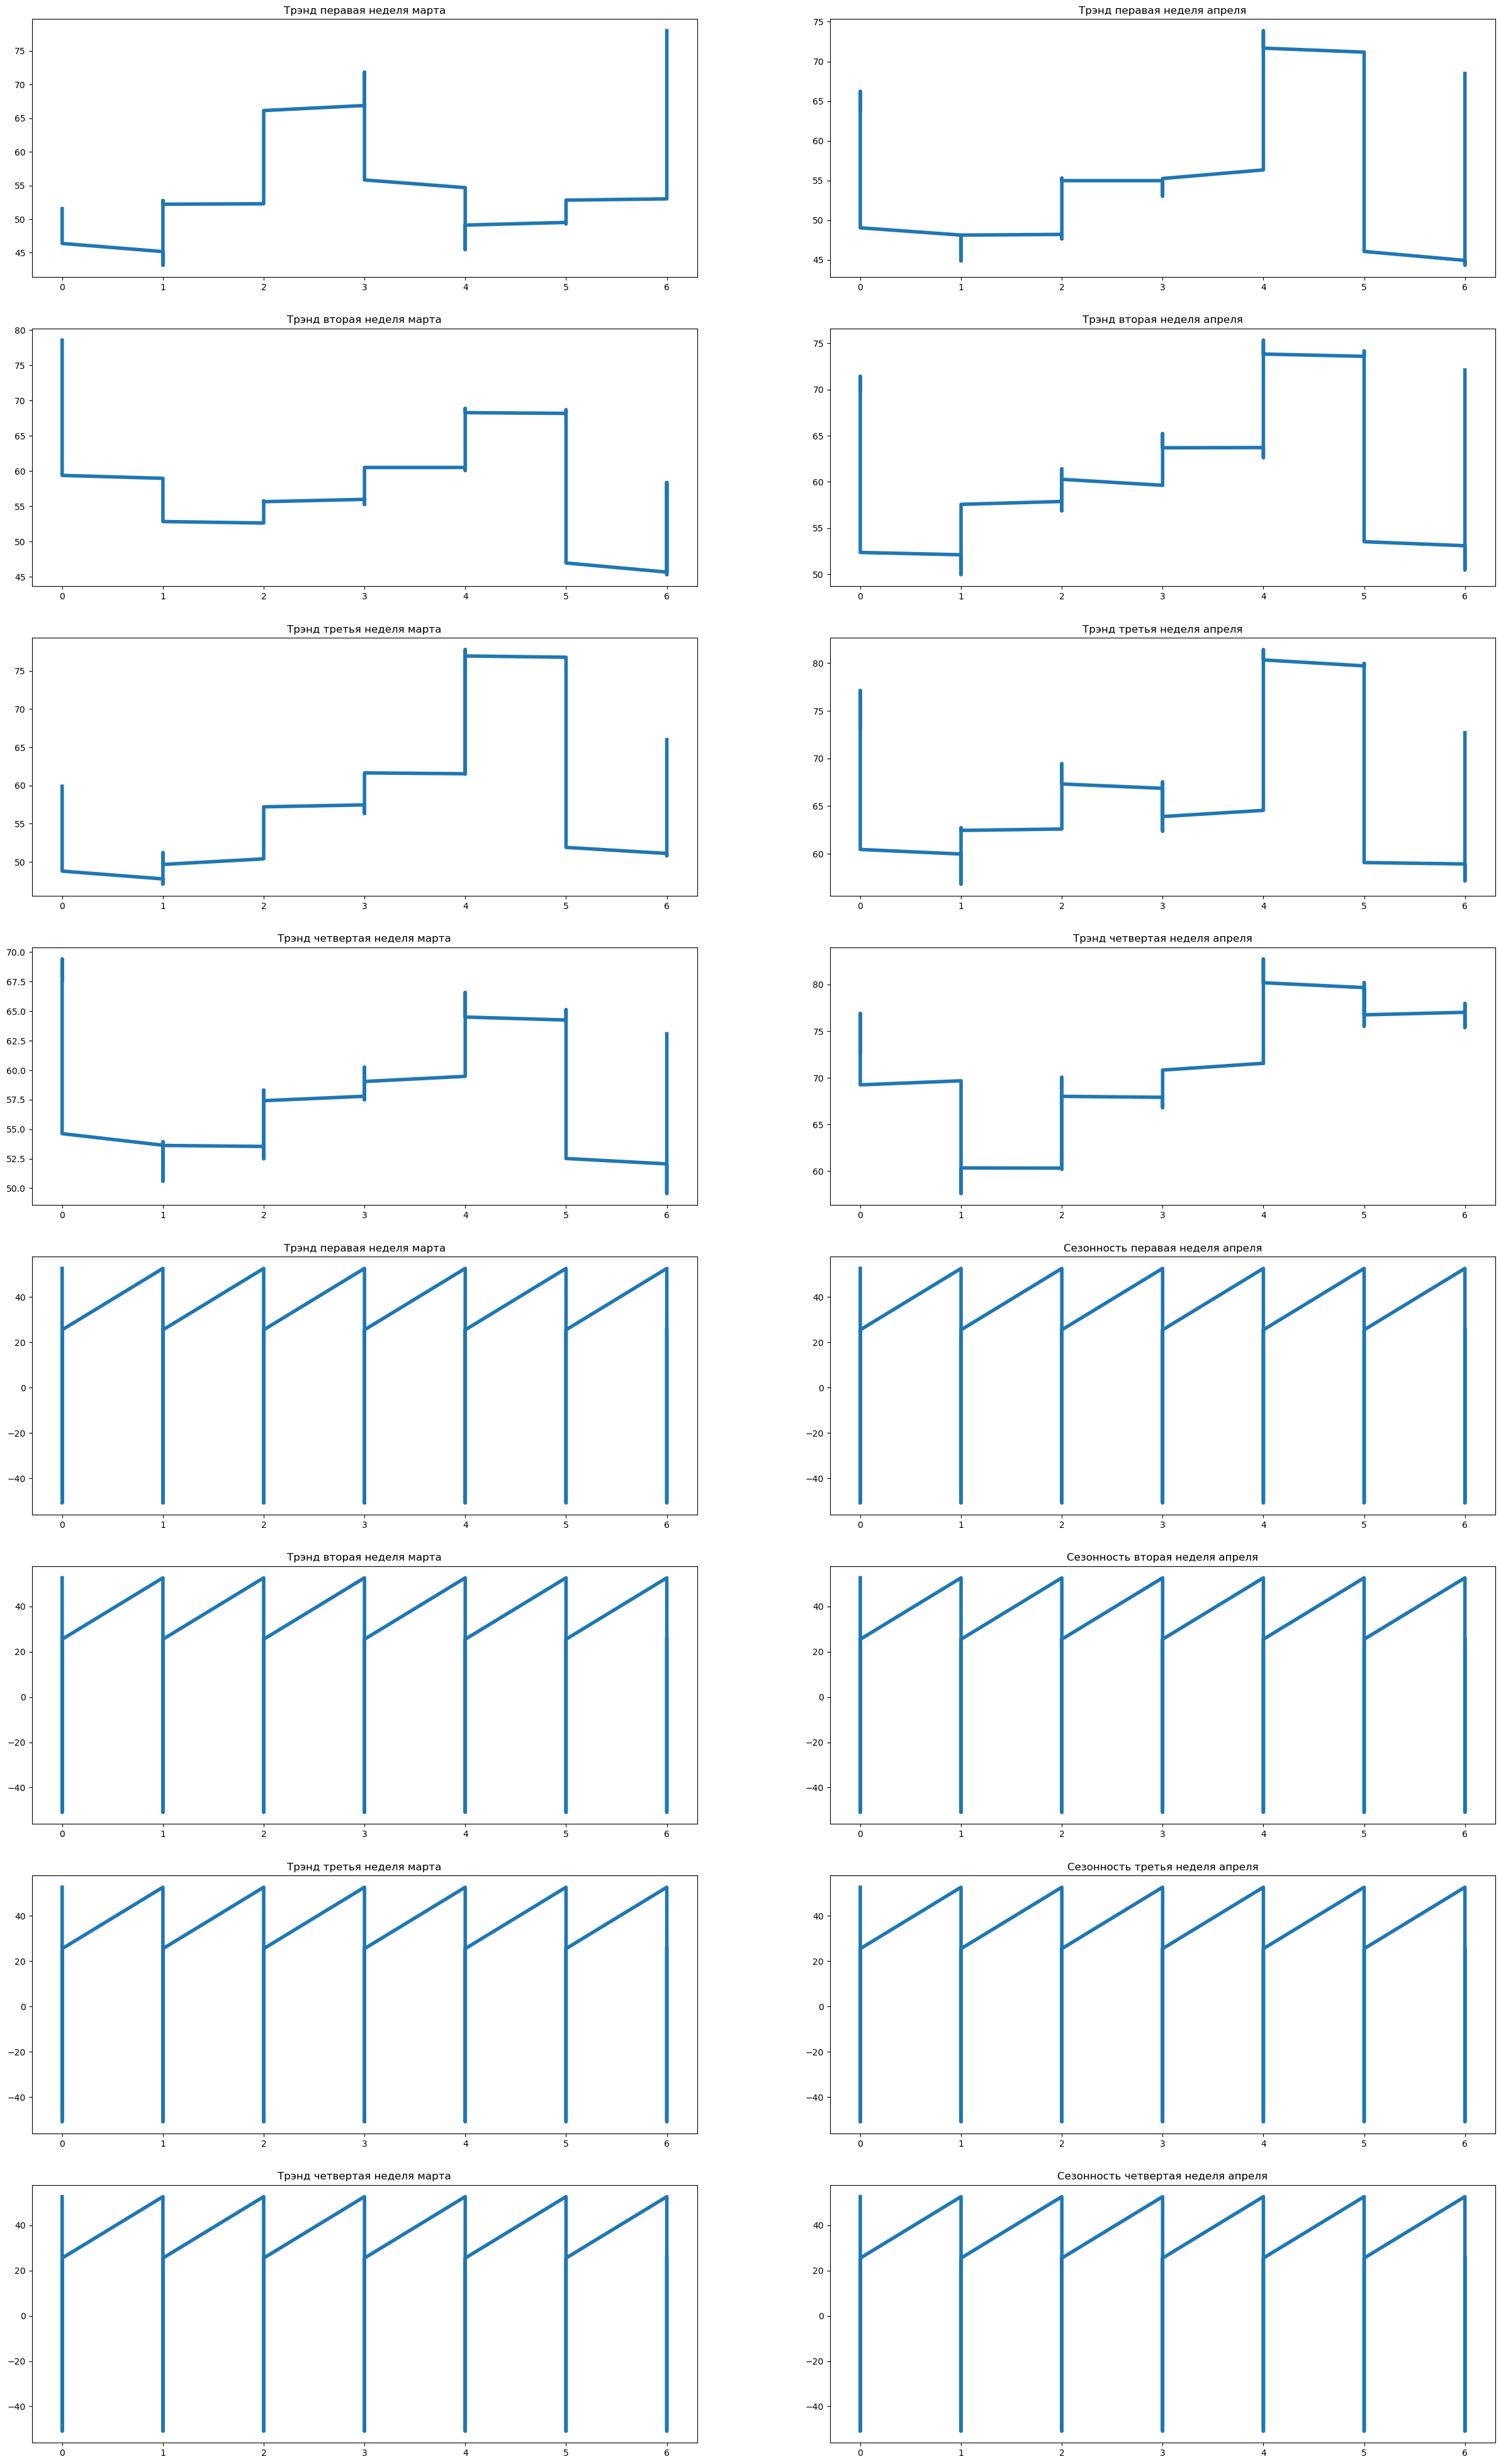

In [ ]:
decomposed_short = seasonal_decompose(df_2["2018-03-05":"2018-04-29"]["num_orders"])
fig2,ax2 = plt.subplots(8,2,figsize = (30,50))
                                     # Трэнд
    # Март
ax2[0][0].plot(decomposed_short.trend["2018-03-05":"2018-03-11"].index.dayofweek,
            decomposed_short.trend["2018-03-05":"2018-03-11"].values,linewidth=4)
ax2[0][0].set_title("Трэнд перавая неделя марта")

ax2[1][0].plot(decomposed_short.trend["2018-03-12":"2018-03-18"].index.dayofweek,
            decomposed_short.trend["2018-03-12":"2018-03-18"].values,linewidth=4)
ax2[1][0].set_title("Трэнд вторая неделя марта")

ax2[2][0].plot(decomposed_short.trend["2018-03-19":"2018-03-25"].index.dayofweek,
            decomposed_short.trend["2018-03-19":"2018-03-25"].values,linewidth=4)
ax2[2][0].set_title("Трэнд третья неделя марта")

ax2[3][0].plot(decomposed_short.trend["2018-03-26":"2018-04-01"].index.dayofweek,
            decomposed_short.trend["2018-03-26":"2018-04-01"].values,linewidth=4)
ax2[3][0].set_title("Трэнд четвертая неделя марта")

    # Апрель
ax2[0][1].plot(decomposed_short.trend["2018-04-02":"2018-04-08"].index.dayofweek,
            decomposed_short.trend["2018-04-02":"2018-04-08"].values,linewidth=4)
ax2[0][1].set_title("Трэнд перавая неделя апреля")

ax2[1][1].plot(decomposed_short.trend["2018-04-09":"2018-04-15"].index.dayofweek,
            decomposed_short.trend["2018-04-09":"2018-04-15"].values,linewidth=4)
ax2[1][1].set_title("Трэнд вторая неделя апреля")

ax2[2][1].plot(decomposed_short.trend["2018-04-16":"2018-04-22"].index.dayofweek,
            decomposed_short.trend["2018-04-16":"2018-04-22"].values,linewidth= 4)
ax2[2][1].set_title("Трэнд третья неделя апреля")

ax2[3][1].plot(decomposed_short.trend["2018-04-23":"2018-04-29"].index.dayofweek,
            decomposed_short.trend["2018-04-23":"2018-04-29"].values,linewidth= 4)
ax2[3][1].set_title("Трэнд четвертая неделя апреля")
                                      # Сезонность
    # Март
ax2[4][0].plot(decomposed_short.seasonal["2018-03-05":"2018-03-11"].index.dayofweek,
            decomposed_short.seasonal["2018-03-05":"2018-03-11"].values,linewidth=4)
ax2[4][0].set_title("Трэнд перавая неделя марта")

ax2[5][0].plot(decomposed_short.seasonal["2018-03-12":"2018-03-18"].index.dayofweek,
            decomposed_short.seasonal["2018-03-12":"2018-03-18"].values,linewidth=4)
ax2[5][0].set_title("Трэнд вторая неделя марта")

ax2[6][0].plot(decomposed_short.seasonal["2018-03-19":"2018-03-25"].index.dayofweek,
            decomposed_short.seasonal["2018-03-19":"2018-03-25"].values,linewidth=4)
ax2[6][0].set_title("Трэнд третья неделя марта")

ax2[7][0].plot(decomposed_short.seasonal["2018-03-26":"2018-04-01"].index.dayofweek,
            decomposed_short.seasonal["2018-03-26":"2018-04-01"].values,linewidth=4)
ax2[7][0].set_title("Трэнд четвертая неделя марта")

    # Апрель
ax2[4][1].plot(decomposed_short.seasonal["2018-04-02":"2018-04-08"].index.dayofweek,
            decomposed_short.seasonal["2018-04-02":"2018-04-08"].values,linewidth=4)
ax2[4][1].set_title("Сезонность перавая неделя апреля")

ax2[5][1].plot(decomposed_short.seasonal["2018-04-09":"2018-04-15"].index.dayofweek,
            decomposed_short.seasonal["2018-04-09":"2018-04-15"].values,linewidth=4)
ax2[5][1].set_title("Сезонность вторая неделя апреля")

ax2[6][1].plot(decomposed_short.seasonal["2018-04-16":"2018-04-22"].index.dayofweek,
            decomposed_short.seasonal["2018-04-16":"2018-04-22"].values,linewidth= 4)
ax2[6][1].set_title("Сезонность третья неделя апреля")

ax2[7][1].plot(decomposed_short.seasonal["2018-04-23":"2018-04-29"].index.dayofweek,
            decomposed_short.seasonal["2018-04-23":"2018-04-29"].values,linewidth= 4)
ax2[7][1].set_title("Сезонность четвертая неделя апреля")

Здесь мы можем увидеть,сезонность остается неизменной на протяжении всего исследуемого периода, в начале каждого дня у нас пик, потом резкое падение, затем в течение дня количество заказов растет и к концу дня достигает нового пика. Можно заметить тренд на рост числа заказов в понедельник, тренд на падение заказов во вторник, который со 2 недели апреля меняется на рост. А так же тренд на рост заказов во второй половине недели

## Подготовка данных и обучение

In [ ]:
train,test = train_test_split(df_2,shuffle = False, random_state = 44, test_size = 0.2)
valid,test = train_test_split(test,shuffle = False, random_state = 44, test_size = 0.5)
# В результате, переменная train будет содержать 80% исходной выборки, test - 10%, а valid - 10%.

In [ ]:
train = train.dropna()

In [ ]:
(train_features, valid_features, test_features) = (train.drop('num_orders',axis = 1),
                                                   valid.drop('num_orders',axis = 1),
                                                   test.drop('num_orders',axis = 1))
(train_target, valid_target, test_target) = (train['num_orders'],
                                             valid['num_orders'],
                                             test['num_orders'])

In [ ]:
%%time
# Создаем объект модели линейной регрессии
model = LinearRegression()

# Обучаем модель на тренировочных данных
model.fit(train_features, train_target)

# Получаем прогноз на валидационных данных
valid_pred = model.predict(valid_features)

# Получаем оценку точности модели на валидационных данных
valid_score = model.score(valid_features, valid_target)

CPU times: total: 93.8 ms
Wall time: 11 ms


In [ ]:
%%time
# Создание экземпляра класса DecisionTreeRegressor
dt = DecisionTreeRegressor()

# Обучение модели на обучающих данных
dt.fit(train_features, train_target)

# Применение модели для предсказания значений на валидационных данных
valid_preds = dt.predict(valid_features)

CPU times: total: 641 ms
Wall time: 105 ms


In [ ]:
%%time
# TimeSeriesSplit
splits = TimeSeriesSplit(n_splits=3)
# RandomForest
RF = RandomForestRegressor(random_state=44)
parametrs = {"max_depth": [1,10],"n_estimators":[100,150,11]}

RF_grid = GridSearchCV(RF,parametrs,cv = splits,verbose=True,n_jobs=-1)
RF_grid.fit(train_features,train_target)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
CPU times: total: 5.06 s
Wall time: 15.2 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(random_state=44), n_jobs=-1,
             param_grid={'max_depth': [1, 10], 'n_estimators': [100, 150, 11]},
             verbose=True)

In [ ]:
%%time
# CatBoost
catboost = CatBoostRegressor(loss_function='RMSE',random_state = 44)
parameters_cat = {'depth':[5,11], 'learning_rate':np.arange(0.1,1,0.2)}
catboost_grid = catboost.grid_search(parameters_cat,
            Pool(train_features,train_target),cv=splits,verbose=True)
final_cat = CatBoostRegressor(depth=catboost_grid["params"]["depth"],
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=100)
final_cat.fit(Pool(train_features,train_target))

0:	learn: 70.0039653	test: 95.3216000	best: 95.3216000 (0)	total: 146ms	remaining: 2m 25s
1:	learn: 64.3837416	test: 88.7119375	best: 88.7119375 (1)	total: 148ms	remaining: 1m 13s
2:	learn: 59.1139285	test: 82.6211968	best: 82.6211968 (2)	total: 150ms	remaining: 49.9s
3:	learn: 54.4864366	test: 76.7558090	best: 76.7558090 (3)	total: 152ms	remaining: 37.9s
4:	learn: 50.3180756	test: 71.7274019	best: 71.7274019 (4)	total: 154ms	remaining: 30.7s
5:	learn: 46.7576426	test: 67.6040695	best: 67.6040695 (5)	total: 156ms	remaining: 25.9s
6:	learn: 43.5570190	test: 63.7324687	best: 63.7324687 (6)	total: 159ms	remaining: 22.5s
7:	learn: 40.9053562	test: 60.3476913	best: 60.3476913 (7)	total: 161ms	remaining: 19.9s
8:	learn: 38.4398485	test: 56.9111410	best: 56.9111410 (8)	total: 163ms	remaining: 17.9s
9:	learn: 36.1397675	test: 54.1874752	best: 54.1874752 (9)	total: 165ms	remaining: 16.4s
10:	learn: 34.1386379	test: 51.2606917	best: 51.2606917 (10)	total: 167ms	remaining: 15.1s
11:	learn: 32.615

In [ ]:
%%time
# LightGBM
lgb_train = lgb.Dataset(train_features,train_target)
lgb_valid = lgb.Dataset(valid_features,valid_target, reference=lgb_train)
parameters_light = {'metric': 'l2', 'max_depth':10,"random_state": 44,"learning_rate":0.1}
light = lgb.train(parameters_light,
                lgb_train,
                num_boost_round=1000,
                valid_sets=[lgb_train,lgb_valid],
                verbose_eval=100)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4524
[LightGBM] [Info] Number of data points in the train set: 3508, number of used features: 28
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 74.427024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

C:\Users\www\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's l2: 130.313	valid_1's l2: 1098.43
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

## Проверим данные на  выборке

In [ ]:
                           # Valid
    # LinearRegression
preds_LR_valid = RF_grid.best_estimator_.predict(valid_features)
    # DecisionTreeRegressor
preds_DT_valid = RF_grid.best_estimator_.predict(valid_features)
    # RandomForest
preds_RF_valid = RF_grid.best_estimator_.predict(valid_features)
    # CatBoost
preds_Cat_valid = final_cat.predict(valid_features)
    #LightGBM
preds_Light_valid = light.predict(valid_features)

                             # Train
    # LinearRegression
preds_LR_train = RF_grid.best_estimator_.predict(train_features)
    # DecisionTreeRegressor
preds_DT_train = RF_grid.best_estimator_.predict(train_features)
    # RandomForest
preds_RF_train = RF_grid.best_estimator_.predict(train_features)
    # CatBoost
preds_Cat_train = final_cat.predict(train_features)
    #LightGBM
preds_Light_train = light.predict(train_features)

In [ ]:
                                #Train
    # LinearRegression
RMSE_LR_train = (mean_squared_error(train_target,preds_LR_train))**0.5
    # DecisionTreeRegressor
RMSE_DT_train = (mean_squared_error(train_target,preds_DT_train))**0.5
    # RandomForest
RMSE_RF_train = (mean_squared_error(train_target,preds_RF_train))**0.5
    # CatBoost
RMSE_CatBoost_train = (mean_squared_error(train_target,preds_Cat_train))**0.5
    #LightGBM
RMSE_LightGBM_train = (mean_squared_error(train_target,preds_Light_train))**0.5

                                # Valid
    # LinearRegression
RMSE_LR_valid = (mean_squared_error(valid_target,preds_LR_valid))**0.5
    # DecisionTreeRegressor
RMSE_DT_valid = (mean_squared_error(valid_target,preds_DT_valid))**0.5
    # RandomForest
RMSE_RF_valid = (mean_squared_error(valid_target,preds_RF_valid))**0.5
    # CatBoost
RMSE_CatBoost_valid = (mean_squared_error(valid_target,preds_Cat_valid))**0.5
    #LightGBM
RMSE_LightGBM_valid = (mean_squared_error(valid_target,preds_Light_valid))**0.5


In [ ]:
# Создаем словарь данных data, где ключи - названия моделей, а значения - списки, содержащие метрики и время работы моделей
data = {"LinearRegression": [RMSE_LR_train, RMSE_LR_valid, 0.038],
        "DecisionTreeRegressor": [RMSE_DT_train, RMSE_DT_valid, 0.086],
        "RandomForest": [RMSE_RF_train, RMSE_RF_valid, 6.76],
        "CatBoost": [RMSE_CatBoost_train, RMSE_CatBoost_valid, 1.62],
        "LightGBM": [RMSE_LightGBM_train, RMSE_LightGBM_valid, 1.44]
       }

# Создаем DataFrame report из словаря данных data, где индексы - метрики моделей
report = pd.DataFrame(data=data, index=["RMSE(train)", "RMSE(valid)", "Время обучения (секунды)"])

In [ ]:
display(report)

,LinearRegression,DecisionTreeRegressor,RandomForest,CatBoost,LightGBM
RMSE(train),13.547216,13.547216,13.547216,8.065972,0.354357
RMSE(valid),33.590812,33.590812,33.590812,32.926433,33.554376
Время обучения (секунды),0.038000,0.086000,6.760000,1.620000,1.440000


В таблице мы видим, что по условию RMSE нам подходят все модели, но наименьшую ошибку, а так же наименьшее время обучения показала модель построенная на алгоритме CatBoost. По большому счету идет сравнение двух моделей CatBoost и LightGBM. Теперь сравним модели на кросс-валидации

In [ ]:
final_cat.fit(Pool(train_features,train_target)) # обучаем модель на тренировочных данных
train_predictions = final_cat.predict(train_features) # делаем предсказания на валидационных данных
cat_cv_scores = cross_val_score(final_cat, train_features, train_target, cv=splits, scoring='neg_root_mean_squared_error') # оцениваем качество модели на кросс-валидации
cat_cv_rmse = -cat_cv_scores.mean() # считаем среднее RMSE на кросс-валидации
print('Среднее RMSE модели CatBoostRegressor на кросс-валидации:', cat_cv_rmse)

0:	learn: 34.1812595	total: 2.82ms	remaining: 2.81s
100:	learn: 19.8686789	total: 236ms	remaining: 2.1s
200:	learn: 16.9478323	total: 469ms	remaining: 1.87s
300:	learn: 15.1281999	total: 700ms	remaining: 1.62s
400:	learn: 13.6452790	total: 933ms	remaining: 1.39s
500:	learn: 12.4023817	total: 1.16s	remaining: 1.16s
600:	learn: 11.3411722	total: 1.4s	remaining: 928ms
700:	learn: 10.3755817	total: 1.63s	remaining: 695ms
800:	learn: 9.4946964	total: 1.87s	remaining: 465ms
900:	learn: 8.7311809	total: 2.1s	remaining: 230ms
999:	learn: 8.0659722	total: 2.32s	remaining: 0us
0:	learn: 28.3637119	total: 1.79ms	remaining: 1.79s
100:	learn: 13.3552562	total: 139ms	remaining: 1.24s
200:	learn: 9.4079783	total: 279ms	remaining: 1.11s
300:	learn: 6.9044398	total: 419ms	remaining: 973ms
400:	learn: 5.3233973	total: 561ms	remaining: 838ms
500:	learn: 4.0530002	total: 700ms	remaining: 698ms
600:	learn: 3.1397640	total: 842ms	remaining: 559ms
700:	learn: 2.4272810	total: 984ms	remaining: 420ms
800:	lear

In [ ]:
# Создание экземпляра модели с заданными параметрами
final_lgbm = lgb.LGBMRegressor()
# Обучение модели на обучающих данных
final_lgbm.fit(train_features, train_target)
# Выполнение кросс-валидации модели
lgbm_cv_scores = cross_val_score(final_lgbm, train_features, train_target, cv=splits, scoring='neg_root_mean_squared_error')
# Вычисление среднего значения RMSE на кросс-валидации
lgbm_cv_rmse = -lgbm_cv_scores.mean()
print('Среднее RMSE LGBMRegressor на кросс-валидации:', lgbm_cv_rmse)

Среднее RMSE LGBMRegressor на кросс-валидации: 25.122262546881604


In [ ]:
# TimeSeriesSplit
splits = TimeSeriesSplit(n_splits=3)
# RandomForest
RF = RandomForestRegressor(random_state=44)
parametrs = {"max_depth": [1, 11], "n_estimators": [100, 150, 11]}
RF_grid = GridSearchCV(RF, parametrs, cv=5, verbose=True, n_jobs=-1)
RF_grid.fit(train_features, train_target)
# оценка качества на кросс-валидации
RF_cv_scores = cross_val_score(RF_grid.best_estimator_, train_features, train_target, cv=splits, scoring='neg_root_mean_squared_error')
RF_cv_rmse = -RF_cv_scores.mean()
print('Среднее RMSE модели RandomForestRegressor на кросс-валидации:', RF_cv_rmse)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Среднее RMSE модели RandomForestRegressor на кросс-валидации: 25.426241393169146


In [ ]:
# Создание экземпляра класса DecisionTreeRegressor
dt = DecisionTreeRegressor()
# Обучение модели на обучающих данных
dt.fit(train_features, train_target)
# Оценка качества модели на кросс-валидации
dt_cv_scores = cross_val_score(dt, train_features, train_target, cv=splits, scoring='neg_root_mean_squared_error')
# Среднее значение RMSE на кросс-валидации
dt_cv_rmse = -dt_cv_scores.mean()
print('Среднее RMSE модели DecisionTreeRegressor на кросс-валидации:', dt_cv_rmse)

Среднее RMSE модели DecisionTreeRegressor на кросс-валидации: 35.0838742765134


In [ ]:
# Определяем количество фолдов
n_folds = 5
# Выполняем кросс-валидацию модели
lr_cv_scores = cross_val_score(model, train_features, train_target, cv=splits, scoring='neg_mean_squared_error')
# Получаем среднее значение RMSE на кросс-валидации
lr_cv_rmse = (-lr_cv_scores.mean()) ** 0.5
print('Среднее RMSE модели LinearRegression на кросс-валидации:', lr_cv_rmse)

Среднее RMSE модели LinearRegression на кросс-валидации: 26.149639188441412


In [ ]:
# Создаем словарь данных data, где ключи - названия моделей, а значения - списки, содержащие метрики и время работы моделей
data = {"LinearRegression": [lr_cv_rmse],
        "DecisionTreeRegressor": [dt_cv_rmse],
        "RandomForest": [RF_cv_rmse],
        "CatBoost": [cat_cv_rmse],
        "LightGBM": [lgbm_cv_rmse]
       }
# Создаем DataFrame report из словаря данных data, где индексы - метрики моделей
report2 = pd.DataFrame(data=data, index=["Среднее RMSE на кросс-валидации"])

In [ ]:
report2

,LinearRegression,DecisionTreeRegressor,RandomForest,CatBoost,LightGBM
Среднее RMSE на кросс-валидации,26.149639,35.083874,25.426241,24.47989,25.122263


DecisionTreeRegressor и RandomForest показали хороший результат на кросс валидации но показали плохой результат на тестовой выборке, проверим на тестовой выборке CatBoostRegressor

In [ ]:
train_valid_features = pd.concat([train_features, valid_features], axis=0)
train_valid_target = pd.concat([train_target, valid_target], axis=0)
train_valid = pd.concat([train_valid_features, train_valid_target], axis=1)

In [ ]:
final_cat = CatBoostRegressor(depth=catboost_grid["params"]["depth"],
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=100)
final_cat.fit(
    train_valid_features, train_valid_target,
    eval_set=(test_features, test_target),
    verbose=100)

0:	learn: 36.9684097	test: 81.8040087	best: 81.8040087 (0)	total: 2.9ms	remaining: 2.9s
100:	learn: 21.2077745	test: 43.3129099	best: 43.2991937 (99)	total: 245ms	remaining: 2.18s
200:	learn: 18.0903466	test: 40.5935365	best: 40.5935365 (200)	total: 487ms	remaining: 1.94s
300:	learn: 16.1167101	test: 40.3950230	best: 40.3810362 (271)	total: 737ms	remaining: 1.71s
400:	learn: 14.6443081	test: 40.3429205	best: 40.2938168 (353)	total: 987ms	remaining: 1.47s
500:	learn: 13.3327892	test: 40.4242515	best: 40.2454797 (418)	total: 1.24s	remaining: 1.23s
600:	learn: 12.1978267	test: 40.5168233	best: 40.2454797 (418)	total: 1.48s	remaining: 986ms
700:	learn: 11.2670093	test: 40.6063368	best: 40.2454797 (418)	total: 1.74s	remaining: 741ms
800:	learn: 10.4366206	test: 40.6713158	best: 40.2454797 (418)	total: 1.98s	remaining: 493ms
900:	learn: 9.7055129	test: 40.7563396	best: 40.2454797 (418)	total: 2.23s	remaining: 245ms
999:	learn: 9.0050986	test: 40.6398200	best: 40.2454797 (418)	total: 2.48s	re

In [ ]:
# Получаем прогнозы на тестовых данных
test_predictions = final_cat.predict(test_features)
# Вычисляем значение RMSE на тестовых данных
rmse_cat = mean_squared_error(test_target, test_predictions, squared=False)
print('RMSE CatBoostRegressor на тестовой выборке: {:.4f}'.format(rmse_cat))

RMSE CatBoostRegressor на тестовой выборке: 40.2455


RMSE на тестовой выборке: 40. Целевой показатель достигнут

## Вывод

В таблице мы видим, что по условию RMSE нам подходят все модели, но наименьшую ошибку, а так же наименьшее время обучения показала модель построенная на алгоритме CatBoost. По большому счету идет сравнение двух моделей CatBoost и LightGBM, другие модели можно не применять. При сравнении методом кросс валидации CatBoostRegressor показывает лучше метрикуна тестовой выборке: RMSE = 40.2455  предлагаю использовать так как это входит в условие задачи RMSE < 48